# Import Libraries

In [4]:
%%capture
!pip install pyDOE

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == 'cuda': print(torch.cuda.get_device_name())

# Physics Informed Neural Network

In [6]:
class GrossPitaevskiiPINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the 2D Gross-Pitaevskii Equation.

    Parameters
    ----------
    layers : list of int
        Neural network architecture, each entry defines the number of neurons in that layer.
    hbar : float, optional
        Reduced Planck's constant (default is 1.0).
    m : float, optional
        Mass of the particle (default is 1.0).
    g : float, optional
        Interaction strength (default is 100.0).
    """

    def __init__(self, layers, hbar=1.0, m=1.0, g=100.0):
        super(GrossPitaevskiiPINN, self).__init__()
        self.layers = layers
        self.network = self.build_network()
        self.hbar = hbar  # Planck's constant, fixed
        self.m = m  # Particle mass, fixed
        self.g = g  # Interaction strength, fixed

    def build_network(self):
        """
        Build the neural network.

        Returns
        -------
        nn.Sequential
            A PyTorch sequential model representing the neural network architecture.
        """
        layers = []
        for i in range(len(self.layers) - 1):
            layers.append(nn.Linear(self.layers[i], self.layers[i + 1]))
            if i < len(self.layers) - 2:  # Apply activation for hidden layers
                layers.append(nn.Tanh())
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the neural network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor containing spatial points.

        Returns
        -------
        torch.Tensor
            Output tensor representing the predicted solution.
        """
        return self.network(x)

    def compute_potential(self, inputs, V0=1.0, x0=np.pi / 2, y0=np.pi / 2, sigma=0.5):
        """
        Compute the Gaussian potential V(x, y).

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor of spatial coordinates (x, y).
        V0 : float, optional
            Amplitude of the potential (default is 1.0).
        x0 : float, optional
            x-coordinate of the Gaussian center (default is pi/2).
        y0 : float, optional
            y-coordinate of the Gaussian center (default is pi/2).
        sigma : float, optional
            Standard deviation of the Gaussian (default is 0.5).

        Returns
        -------
        torch.Tensor
            Tensor representing the potential at the input spatial points.
        """
        x = inputs[:, 0]
        y = inputs[:, 1]
        V = V0 * torch.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
        return V

    def boundary_loss(self, x_bc, u_bc):
        """
        Compute the boundary loss (MSE) for the boundary conditions.

        Parameters
        ----------
        x_bc : torch.Tensor
            Input tensor of boundary spatial points.
        u_bc : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).

        Returns
        -------
        torch.Tensor
            Mean squared error (MSE) at the boundary points.
        """
        u_pred = self.forward(x_bc)
        y_bc = torch.zeros_like(u_pred)  # Ensure boundary conditions are satisfied
        return torch.mean((u_pred - y_bc) ** 2)

    def riesz_loss(self, predictions, inputs):
        """
        Compute the Riesz energy loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        predictions : torch.Tensor
            Predicted solution from the network.
        inputs : torch.Tensor
            Input tensor of spatial coordinates.

        Returns
        -------
        torch.Tensor
            Riesz energy loss value.
        """
        u = predictions

        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)
        gradients = torch.autograd.grad(outputs=predictions, inputs=inputs,
                                        grad_outputs=torch.ones_like(predictions),
                                        create_graph=True, retain_graph=True)[0]

        laplacian_term = torch.sum(gradients ** 2)  # Kinetic term
        V = self.compute_potential(inputs).unsqueeze(1)
        potential_term = torch.sum(V * u ** 2)  # Potential term
        interaction_term = 0.5 * self.g * torch.sum(u ** 4)  # Interaction term

        riesz_energy = 0.5 * (laplacian_term + potential_term + interaction_term)

        return riesz_energy

    def pde_loss(self, inputs, predictions):
        """
        Compute the PDE loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor of spatial coordinates.
        predictions : torch.Tensor
            Predicted solution from the network.

        Returns
        -------
        tuple
            Tuple containing:
                - torch.Tensor: PDE loss value.
                - torch.Tensor: PDE residual.
                - torch.Tensor: Smallest eigenvalue (lambda).
        """
        u = predictions

        # Compute first and second derivatives with respect to x and y
        u_x = grad(u, inputs, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0]
        u_y = grad(u, inputs, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]

        u_xx = grad(u_x, inputs, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
        u_yy = grad(u_y, inputs, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
        laplacian_u = u_xx + u_yy

        # Compute λ directly from the energy functional
        V = self.compute_potential(inputs)
        lambda_pde = torch.mean(u_x ** 2 + u_y ** 2 + V * u ** 2 + self.g * u ** 4) / torch.mean(u ** 2)

        # Residual of the PDE (Gross-Pitaevskii equation)
        pde_residual = -laplacian_u + V * u + self.g * torch.abs(u ** 2) * u - (lambda_pde * u)

        # Regularization: See https://arxiv.org/abs/2010.05075

        # Term 1: L_f = 1 / (f(x, λ))^2, penalizes the network if the PDE residual is close to zero to avoid trivial eigenfunctions
        L_f = 1 / (torch.mean(u ** 2) + 1e-2)

        # Term 2: L_λ = 1 / λ^2, penalizes small eigenvalues λ, ensuring non-trivial eigenvalues
        L_lambda = 1 / (lambda_pde ** 2 + 1e-6)

        # Term 3: L_drive = e^(-λ + c), encourages λ to grow, preventing collapse to small values
        c = 1.0  # Tunable constant
        L_drive = torch.exp(-lambda_pde + c)

        # PDE loss as the residual plus regularization terms
        pde_loss = torch.mean(pde_residual ** 2) + L_f + L_lambda

        return pde_loss, pde_residual, lambda_pde

    def total_loss(self, x, x_bc, u_bc):
        """
        Compute the total loss combining boundary, Riesz energy, and PDE losses.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of spatial coordinates for the interior points.
        x_bc : torch.Tensor
            Input tensor of boundary spatial points.
        u_bc : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).

        Returns
        -------
        torch.Tensor
            Total loss value.
        """
        data_loss = self.boundary_loss(x_bc, u_bc)
        riesz_energy = self.riesz_loss(self.forward(x), x)
        pde_loss, _, _ = self.pde_loss(x, self.forward(x))
        return data_loss + riesz_energy + pde_loss

# Initialize Weights

In [7]:
def initialize_weights(m):
    """
    Initialize the weights of the neural network layers using Xavier uniform initialization.

    Parameters
    ----------
    m : torch.nn.Module
        A layer of the neural network. If it is a linear layer, its weights and biases are initialized.
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Prepare Training Data

In [8]:
def prepare_training_data(N_u, N_f, center=(np.pi / 2, np.pi / 2), radius=np.pi / 2):
    """
    Generate training data including boundary points and interior collocation points.

    Parameters
    ----------
    N_u : int
        Number of boundary points.
    N_f : int
        Number of collocation points (interior points).
    center : tuple of float, optional
        Center of the circular region (default is (pi/2, pi/2)).
    radius : float, optional
        Radius of the circular region (default is pi/2).

    Returns
    -------
    tuple of np.ndarray
        Tuple containing:
            - X_f_train: Interior points (collocation points).
            - X_u_train: Boundary points.
            - u_train: Boundary conditions (Dirichlet).
    """
    # Generate boundary points along the domain of the potential
    theta = np.linspace(0, 2 * np.pi, N_u)
    circle_x = center[0] + radius * np.cos(theta)
    circle_y = center[1] + radius * np.sin(theta)
    X_u_train = np.column_stack((circle_x, circle_y))
    u_train = np.zeros((X_u_train.shape[0], 1))  # Boundary condition u=0

    # Generate collocation points within the domain of the potential
    collocation_points_x = np.random.uniform(center[0] - radius, center[0] + radius, N_f)
    collocation_points_y = np.random.uniform(center[1] - radius, center[1] + radius, N_f)
    interior_mask = (collocation_points_x - center[0]) ** 2 + (collocation_points_y - center[1]) ** 2 <= radius ** 2
    X_f_train = np.column_stack((collocation_points_x[interior_mask], collocation_points_y[interior_mask]))

    return X_f_train, X_u_train, u_train

# Train PINN

In [9]:
def train_pinn(N_u=500, N_f=10000, layers=[2, 400, 400, 400, 1], epochs=1000):
    """
    Train the Physics-Informed Neural Network (PINN) for the Gross-Pitaevskii equation.

    Parameters
    ----------
    N_u : int, optional
        Number of boundary points (default is 500).
    N_f : int, optional
        Number of collocation points (interior points) for the physics-based loss (default is 10,000).
    layers : list of int, optional
        Architecture of the neural network (default is [2, 400, 400, 400, 1]).
    epochs : int, optional
        Number of training epochs (default is 1000).

    Returns
    -------
    GrossPitaevskiiPINN
        The trained model.
    """
    model = GrossPitaevskiiPINN(layers).to(device)  # Move model to device
    model.apply(initialize_weights)  # Apply weight initialization
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Prepare training data
    X_f_train, X_u_train, u_train = prepare_training_data(N_u, N_f)

    # Convert data to PyTorch tensors and move to device
    X_f_train_tensor = torch.tensor(X_f_train, dtype=torch.float32, requires_grad=True).to(device)
    X_u_train_tensor = torch.tensor(X_u_train, dtype=torch.float32).to(device)
    u_train_tensor = torch.tensor(u_train, dtype=torch.float32).to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Calculate the total loss
        loss = model.total_loss(X_f_train_tensor, X_u_train_tensor, u_train_tensor)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        if epoch % 400 == 0:  # Plot every 400 epochs
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.6f}')
            pde_loss, _, lambda_pde = model.pde_loss(X_f_train_tensor, model.forward(X_f_train_tensor))
            plot_solution(model, num_grid_pts=100, center=(np.pi / 2, np.pi / 2), radius=np.pi / 2, epoch=epoch,
                          lambda_pde=lambda_pde.item())

    return model

# Plot Solution

In [10]:
def plot_solution(model, num_grid_pts=100, center=(np.pi / 2, np.pi / 2), radius=np.pi / 2, epoch=0, lambda_pde=0):
    """
    Plot the predicted solution of the Gross-Pitaevskii equation.

    Parameters
    ----------
    model : GrossPitaevskiiPINN
        The trained PINN model.
    num_grid_pts : int, optional
        Number of grid points for plotting the solution (default is 100).
    center : tuple of float, optional
        Center of the circular region for plotting (default is (pi/2, pi/2)).
    radius : float, optional
        Radius of the circular region for plotting (default is pi/2).
    epoch : int, optional
        The current training epoch, used in the plot title (default is 0).
    lambda_pde : float, optional
        The smallest eigenvalue from the PDE loss, used in the plot title (default is 0).
    """
    x_vals = np.linspace(center[0] - radius, center[0] + radius, num_grid_pts)
    y_vals = np.linspace(center[1] - radius, center[1] + radius, num_grid_pts)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Prepare test data
    X_test = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    # Predict the solution using the trained model
    u_pred = model(X_test_tensor).detach().cpu().numpy().reshape((num_grid_pts, num_grid_pts))

    plt.figure(figsize=(8, 6))
    plt.pcolor(X, Y, u_pred, shading='auto', cmap='viridis')
    plt.colorbar(label='Predicted Solution $u_{pred}$')
    plt.title(
        f'Predicted Solution of the Gross-Pitaevskii Equation\nEpoch: {epoch}, Smallest Eigenvalue: {lambda_pde:.4f}')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.xlim([center[0] - radius, center[0] + radius])
    plt.ylim([center[1] - radius, center[1] + radius])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(['Smallest Eigenvalue'])
    plt.show()

# Main

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/2001], Loss: 21942.966797


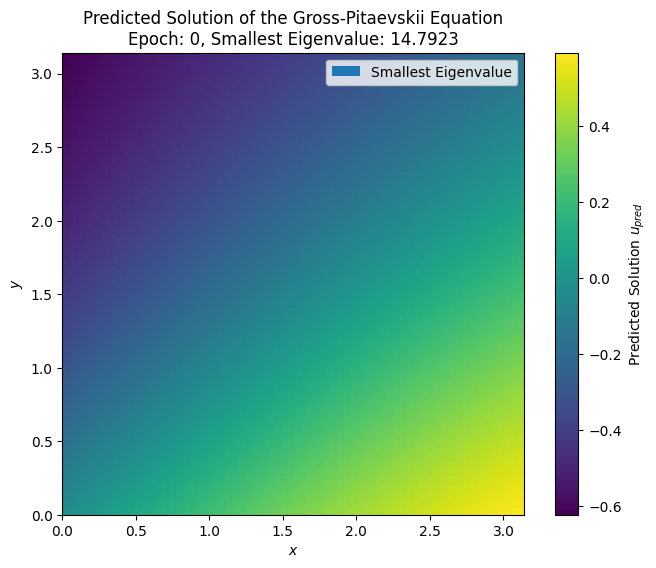

Epoch [400/2001], Loss: 75.360519


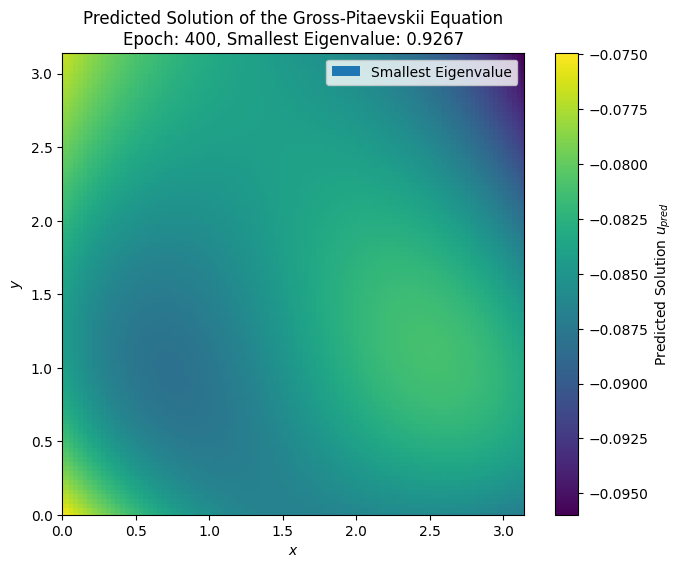

Epoch [800/2001], Loss: 75.186951


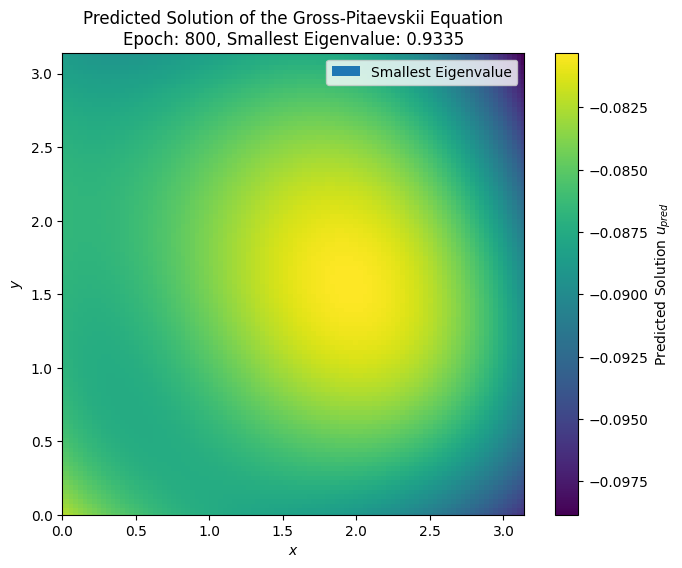

Epoch [1200/2001], Loss: 75.175095


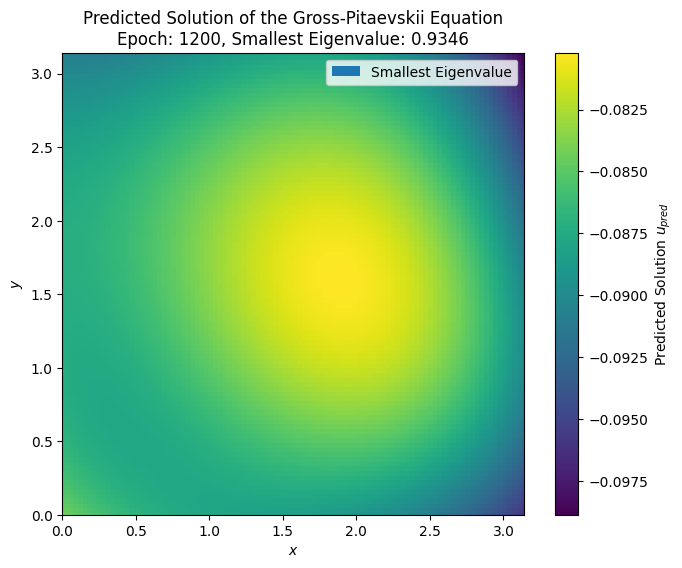

Epoch [1600/2001], Loss: 75.165947


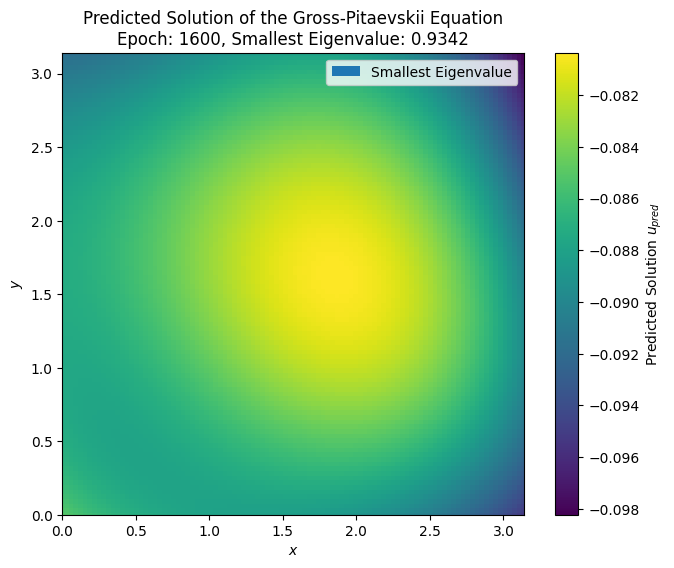

Epoch [2000/2001], Loss: 75.158134


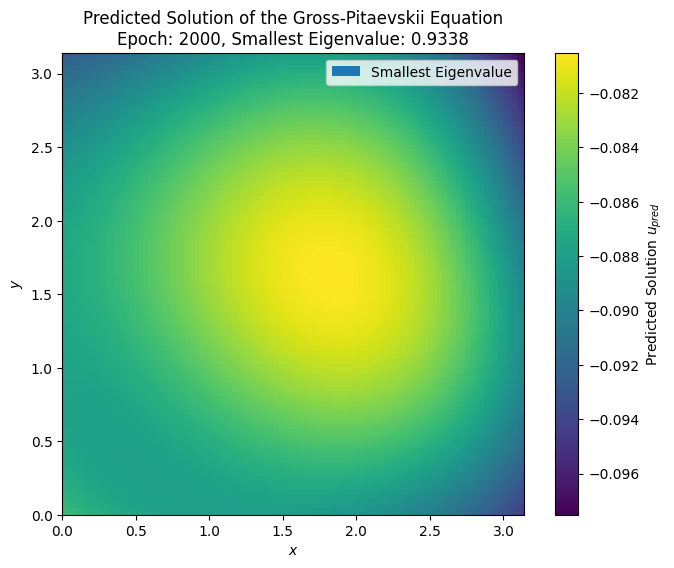

In [11]:
N_u = 500  # Number of boundary points
N_f = 10000  # Number of collocation points
layers = [2, 100, 100, 100, 1]  # Neural network architecture
epochs = 2001  # Number of training epochs

# Train the PINN
model = train_pinn(N_u=N_u, N_f=N_f, layers=layers, epochs=epochs)